# References

- (torch) https://pytorch.org/docs/stable/generated/torch.jit.optimize_for_inference.html
- (reproducibility) https://pytorch.org/docs/stable/notes/randomness.html
- (torchscript) https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html
- (onnx export) https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html
- (import example) https://colab.research.google.com/github/PyThaiNLP/tutorials/blob/master/source/notebooks/thai_wav2vec2_onnx.ipynb#scrollTo=5-lBGrVVj0i_
- (onnx FP16) https://github.com/onnx/onnx-docker/blob/master/onnx-ecosystem/converter_scripts/float32_float16_onnx.ipynb
- (onnxruntime) https://onnxruntime.ai/docs/get-started/with-python.html
- (tensorrt saving, inference) https://developer.nvidia.com/blog/speeding-up-deep-learning-inference-using-tensorflow-onnx-and-tensorrt/
- (tensorrt inference, fixed) https://stackoverflow.com/questions/59280745/inference-with-tensorrt-engine-file-on-python
- (torch-tensorrt) https://developer.nvidia.com/blog/accelerating-inference-up-to-6x-faster-in-pytorch-with-torch-tensorrt/
- (torch-tensorrt python) https://nvidia.github.io/Torch-TensorRT/tutorials/getting_started_with_python_api.html
- model info: https://huggingface.co/facebook/wav2vec2-base-960h

In [1]:
%matplotlib inline

In [2]:
# for reproducibility with CUDA 11+ and GPU inference
import os
os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'

In [3]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxmltools
import onnxruntime
import pycuda.driver as cuda
import pycuda.autoinit 
import random
import time
import tensorrt as trt
import torch
import torch.onnx
import torch_tensorrt
import torch.backends.cudnn as cudnn
import tqdm
import seaborn as sns
import soundfile as sf

from datasets import load_dataset
from datasets import load_metric
from torchaudio.models.wav2vec2.utils import import_huggingface_model
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from pynvml import *
nvmlInit()


In [4]:
# reduce randomness for reproducibility
torch.manual_seed(1337)
random.seed(1337)
np.random.seed(1337)
# torch.use_deterministic_algorithms(True) # error with cuda 11+

### check import versions, cuda support

In [5]:
!dpkg -l | grep nvinfer

ii  libnvinfer-bin                  8.2.1-1+cuda11.4                  amd64        TensorRT binaries
ii  libnvinfer-dev                  8.2.1-1+cuda11.4                  amd64        TensorRT development libraries and headers
ii  libnvinfer-plugin-dev           8.2.1-1+cuda11.4                  amd64        TensorRT plugin libraries and headers
ii  libnvinfer-plugin8              8.2.1-1+cuda11.4                  amd64        TensorRT plugin library
ii  libnvinfer8                     8.2.1-1+cuda11.4                  amd64        TensorRT runtime libraries


In [6]:
print("pytorch version:", torch.__version__)
print("pytorch cuda?  :", torch.cuda.is_available())

pytorch version: 1.10.1+cu113
pytorch cuda?  : True


In [7]:
print("onnxruntime version:", onnxruntime.__version__)
print("onnxruntime device :", onnxruntime.get_device())

onnxruntime version: 1.9.0
onnxruntime device : GPU


In [8]:
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print("GPU 0 stats:")
print(f'total    : {info.total/1024.:>11.2f} MB')
print(f'free     : {info.free/1024.:>11.2f} MB')
print(f'used     : {info.used/1024.:>11.2f} MB')

GPU 0 stats:
total    : 11534336.00 MB
free     : 11125440.00 MB
used     :   408896.00 MB


## export HuggingFace to PyTorch

huggingface has a direct onnx export, but it only supports some model types, not including wav2vec.

`torchaudio` has a utility to import HuggingFace Wav2Vec2 models, so we'll import the model to pytorch and export with pyotrch's onnx export

In [9]:
# sample data for testing
dataset = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean")

Reusing dataset librispeech_asr (/root/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr/clean/2.1.0/f2c70a4d03ab4410954901bde48c54b85ca1b7f9bf7d616e7e2a72b5ee6ddbfc)


  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
dataset['validation'][0]["audio"]["array"].shape

(93680,)

In [11]:
# dummy input
AUDIO_MAXLEN = 100000
dummy_input = torch.randn(1, AUDIO_MAXLEN, requires_grad=True)

In [12]:
# (down)load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
hugging_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# import as native pytorch model
_ = hugging_model.eval()
imported_model = import_huggingface_model(hugging_model)
gpu_model = import_huggingface_model(hugging_model)
_ = imported_model.eval()
_ = gpu_model.eval()

(1, 100000)


<AxesSubplot:>

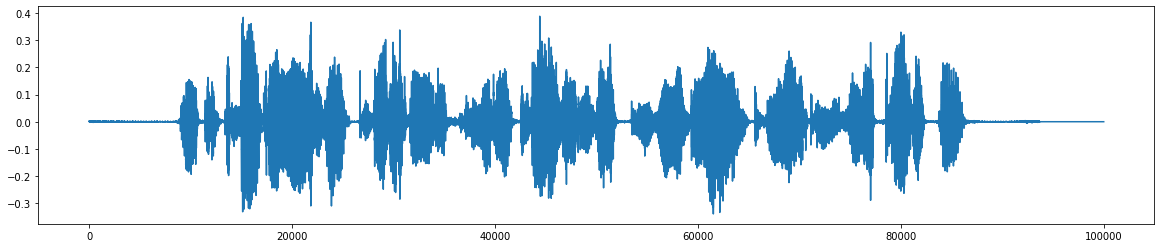

In [14]:
# fix input for all tests using sample librispeech data
speech_input = np.expand_dims(np.pad(dataset['validation'][0]["audio"]["array"][:AUDIO_MAXLEN], (0, AUDIO_MAXLEN-len(dataset['validation'][0]["audio"]["array"][:AUDIO_MAXLEN]))), 0)
print(speech_input.shape)
plt.rcParams["figure.figsize"] = (20,4)
sns.lineplot(data=speech_input[0])

### compare model outputs

In [15]:
hugging_model.to("cuda")
r = hugging_model(torch.from_numpy(speech_input).to("cuda"))
hugging_prediction = r.logits.detach().cpu().numpy()
print(hugging_prediction.shape)

(1, 312, 32)


In [16]:
gpu_model.to("cuda")
_ = gpu_model.eval()
print(next(gpu_model.parameters()).is_cuda)

True


In [17]:
torch_prediction = gpu_model(torch.from_numpy(speech_input).to("cuda"))[0].detach().cpu().numpy()
print(torch_prediction.shape)

(1, 312, 32)


In [18]:
print(np.allclose(hugging_prediction, torch_prediction))

True


## export PyTorch to ONNX

In [19]:
# export with native torch onnx
torch.onnx.export(imported_model,     # model being run 
     dummy_input,                     # model input (or a tuple for multiple inputs) 
     "wav2vec2-ctc.onnx",             # where to save the model  
     export_params=True,              # store the trained parameter weights inside the model file 
     opset_version=14,                # the ONNX version to export the model to. max supported in this notebook setup is 14
     do_constant_folding=True,        # whether to execute constant folding for optimization 
     input_names = ['modelInput'],    # the model's input names 
     output_names = ['modelOutput'],  # the model's output names 
     dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes 
                   'modelOutput' : {0 : 'batch_size'}}) 

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:2359: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  _verify_batch_size([input.size(0) * input.size(1) // num_groups, num_groups] + list(input.size()[2:]))
/usr/local/lib/python3.8/dist-packages/torch/onnx/symbolic_helper.py:716: UserWarning: allowzero=0 by default. In order to honor zero value in shape use allowzero=1
  warnings.warn("allowzero=0 by default. In order to honor zero value in shape use allowzero=1")


In [20]:
# convert to fp16
s = time.perf_counter()
onnx_model = onnxmltools.utils.load_model("wav2vec2-ctc.onnx")
onnx_model = onnxmltools.utils.float16_converter.convert_float_to_float16(onnx_model)
onnxmltools.utils.save_model(onnx_model, "wav2vec2-ctc.fp16.onnx")
e = time.perf_counter()
time.sleep(0.5)
print(f"converted model to fp16 in: {(e-s):.3f} s")

converted model to fp16 in: 1.528 s


## (not working on wav2vec) export PyTorch to TRT with torch_tensorrt

torch_tensorrt (TRTorch) uses TorchScript as an intermediate format, so test conversion with `torch.jit.script()` and `torch.jit.trace()`.

then, demonstrate working conversion on a small test model.

however, kernel dies (segfault) when converting actual model...

In [21]:
# scripting works
scripted_model = torch.jit.script(imported_model)

Removing weight_norm from ConvolutionalPositionalEmbedding


In [22]:
# tracing raises an error
try:
    traced_model = torch.jit.trace(imported_model, dummy_input, strict=False)
except Exception as e:
    print(f"error: {type(e).__name__}: {str(e)}")

error: RuntimeError: Only tensors, lists, tuples of tensors, or dictionary of tensors can be output from traced functions


In [23]:
test_model = torch.nn.Sequential(
    torch.nn.Linear(100, 100),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU()
)

trt_test_model = torch_tensorrt.compile(test_model, 
    inputs= [torch_tensorrt.Input((1, 100))],
    enabled_precisions= {torch_tensorrt.dtype.float, torch_tensorrt.dtype.half} # Run with FP16
)

In [24]:
# # THIS WILL FAIL...
# trt_model = torch_tensorrt.compile(imported_model, 
#     inputs= [torch_tensorrt.Input((1, AUDIO_MAXLEN))],
#     enabled_precisions= {torch_tensorrt.dtype.float, torch_tensorrt.dtype.half} # Run with FP16
# )

### export ONNX to TensorRT

In [25]:
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)

In [26]:
# export helper functions for tensorRT
# adapted for wav2vec from https://developer.nvidia.com/blog/speeding-up-deep-learning-inference-using-tensorflow-onnx-and-tensorrt/

def build_engine(onnx_path, shape):
    with trt.Builder(TRT_LOGGER) as builder, \
        builder.create_network(1) as network, \
        builder.create_builder_config() as config, \
        trt.OnnxParser(network, TRT_LOGGER) as parser:
        config.max_workspace_size = (256 << 20)
        with open(onnx_path, 'rb') as model:
            parser.parse(model.read())
            network.get_input(0).shape = shape
            engine = builder.build_engine(network, config)
            return engine

def save_engine(engine, file_name):
    buf = engine.serialize()
    with open(file_name, 'wb') as f:
        f.write(buf)
        
def load_engine(trt_runtime, plan_path):
    with open(plan_path, 'rb') as f:
        engine_data = f.read()
    engine = trt_runtime.deserialize_cuda_engine(engine_data)
    return engine

In [27]:
s = time.perf_counter()

onnx_file_name = 'wav2vec2-ctc.onnx'
tensorrt_file_name = 'wav2vec2-ctc.trt'
input_shape = [1, AUDIO_MAXLEN]

engine = build_engine(onnx_file_name, input_shape)
save_engine(engine, tensorrt_file_name) 

e = time.perf_counter()
time.sleep(0.5)
print(f"time for trt export: {e-s:.3f} s")
print(f"model exported as  : {tensorrt_file_name}")

[01/15/2022-05:50:34] [TRT] [W] parsers/onnx/onnx2trt_utils.cpp:364: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.


/tmp/ipykernel_1070/44071790.py:13: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)


time for trt export: 29.813 s
model exported as  : wav2vec2-ctc.trt


In [28]:
s = time.perf_counter()

onnx_fp16_file_name = 'wav2vec2-ctc.fp16.onnx'
tensorrt_fp16_file_name = 'wav2vec2-ctc.fp16.trt'
input_shape = [1, AUDIO_MAXLEN]

engine = build_engine(onnx_fp16_file_name, input_shape)
save_engine(engine, tensorrt_fp16_file_name) 

e = time.perf_counter()
time.sleep(0.5)
print(f"time for trt export: {e-s:.3f} s")
print(f"model exported as {tensorrt_fp16_file_name}")

/tmp/ipykernel_1070/44071790.py:13: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)


time for trt export: 26.269 s
model exported as wav2vec2-ctc.fp16.trt


# ======================== INFERENCE ========================

In [29]:
test_iters = 512

## test PyTorch vs ONNX inference

In [31]:
s = time.perf_counter()
with torch.no_grad():
    for _ in tqdm.trange(test_iters):
        prediction = gpu_model(torch.from_numpy(speech_input).to("cuda"))
e = time.perf_counter()
time.sleep(0.5)
torch_inference = e - s
print(f"time for torch GPU inference: {torch_inference*1000./test_iters:.3f} ms per inference")

100%|███████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 77.10it/s]


time for torch GPU inference: 12.977 ms per inference


In [32]:
# unallocate this vram (it won't be released though fyi)
del gpu_model

In [33]:
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print("GPU 0 stats:")
print(f'total    : {info.total/1024.:>11.2f} MB')
print(f'free     : {info.free/1024.:>11.2f} MB')
print(f'used     : {info.used/1024.:>11.2f} MB')

GPU 0 stats:
total    : 11534336.00 MB
free     :  6459072.00 MB
used     :  5075264.00 MB


### ONNX

In [34]:
print(f"loading model '{onnx_file_name}'")
ort_model = onnxruntime.InferenceSession(onnx_file_name)

loading model 'wav2vec2-ctc.onnx'


/usr/local/lib/python3.8/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:350: UserWarning: Deprecation warning. This ORT build has ['CUDAExecutionProvider', 'CPUExecutionProvider'] enabled. The next release (ORT 1.10) will require explicitly setting the providers parameter (as opposed to the current behavior of providers getting set/registered by default based on the build flags) when instantiating InferenceSession.For example, onnxruntime.InferenceSession(..., providers=["CUDAExecutionProvider"], ...)
  warnings.warn("Deprecation warning. This ORT build has {} enabled. ".format(available_providers) +


In [35]:
speech = np.copy(speech_input).astype(np.float32)
ort_inputs = {"modelInput": speech}
ort_outs = ort_model.run(None, ort_inputs)
ort32_prediction = np.array(ort_outs)[0]
print(ort32_prediction.shape)

(1, 312, 32)


In [36]:
s = time.perf_counter()
for _ in tqdm.trange(test_iters):
    ort_outs = ort_model.run(None, ort_inputs)
e = time.perf_counter()
time.sleep(0.5)
ort32_inference = e - s
print(f"time for onnx-runtime fp32 GPU inference: {ort32_inference*1000./test_iters:.3f} ms per inference")

100%|███████████████████████████████████████████████████████████████████| 512/512 [00:07<00:00, 66.29it/s]


time for onnx-runtime fp32 GPU inference: 15.090 ms per inference


In [37]:
del ort_model
time.sleep(1)

In [38]:
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print("GPU 0 stats:")
print(f'total    : {info.total/1024.:>11.2f} MB')
print(f'free     : {info.free/1024.:>11.2f} MB')
print(f'used     : {info.used/1024.:>11.2f} MB')

GPU 0 stats:
total    : 11534336.00 MB
free     :  6405824.00 MB
used     :  5128512.00 MB


### ONNX FP16

In [39]:
print(f"loading model '{onnx_fp16_file_name}'")
ort16_model = onnxruntime.InferenceSession(onnx_fp16_file_name)

loading model 'wav2vec2-ctc.fp16.onnx'


In [40]:
speech16 = np.copy(speech_input).astype(np.float16)
ort16_inputs = {"modelInput": speech16}
ort16_outs = ort16_model.run(None, ort16_inputs)
ort16_prediction = np.array(ort16_outs[0])
print(ort16_prediction.shape)

(1, 312, 32)


In [41]:
ort16_inputs = {"modelInput": speech16}
s = time.perf_counter()
for _ in tqdm.trange(test_iters):
    ort_outs = ort16_model.run(None, ort16_inputs)
e = time.perf_counter()
time.sleep(0.5)
ort16_inference = e - s
print(f"time for onnx-runtime fp16 GPU inference: {ort16_inference*1000./test_iters:.3f} ms per inference")

100%|██████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 129.84it/s]


time for onnx-runtime fp16 GPU inference: 7.707 ms per inference


In [42]:
del ort16_model
time.sleep(1)

In [43]:
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print("GPU 0 stats:")
print(f'total    : {info.total/1024.:>11.2f} MB')
print(f'free     : {info.free/1024.:>11.2f} MB')
print(f'used     : {info.used/1024.:>11.2f} MB')

GPU 0 stats:
total    : 11534336.00 MB
free     :  6405824.00 MB
used     :  5128512.00 MB


### TensorRT

In [44]:
# stackoverflow coming through to fix nvidia's example
# https://stackoverflow.com/questions/59280745/inference-with-tensorrt-engine-file-on-python

class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        self.host = host_mem
        self.device = device_mem

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()

    
class TRTModel:
    
    def __init__(self,engine_path, max_batch_size=1, dtype=np.float32):
        
        self.engine_path = engine_path
        self.dtype = dtype
        self.logger = trt.Logger(trt.Logger.WARNING)
        self.runtime = trt.Runtime(self.logger)
        self.engine = self.load_engine(self.runtime, self.engine_path)
        self.max_batch_size = max_batch_size
        self.inputs, self.outputs, self.bindings, self.stream = self.allocate_buffers()
        self.context = self.engine.create_execution_context()
    
    @staticmethod
    def load_engine(trt_runtime, engine_path):
        trt.init_libnvinfer_plugins(None, "")             
        with open(engine_path, 'rb') as f:
            engine_data = f.read()
        engine = trt_runtime.deserialize_cuda_engine(engine_data)
        return engine
    
    def allocate_buffers(self):
        
        inputs = []
        outputs = []
        bindings = []
        stream = cuda.Stream()
        
        for binding in self.engine:
            size = trt.volume(self.engine.get_binding_shape(binding)) * self.max_batch_size
            host_mem = cuda.pagelocked_empty(size, self.dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)
            
            bindings.append(int(device_mem))

            if self.engine.binding_is_input(binding):
                inputs.append(HostDeviceMem(host_mem, device_mem))
            else:
                outputs.append(HostDeviceMem(host_mem, device_mem))
        
        return inputs, outputs, bindings, stream
       
            
    def __call__(self,x:np.ndarray, dim_1=312, dim_2=32):
        x = x.astype(self.dtype)
        np.copyto(self.inputs[0].host,x.ravel())
        for inp in self.inputs:
            cuda.memcpy_htod_async(inp.device, inp.host, self.stream)
        self.context.execute_async(batch_size=self.max_batch_size, bindings=self.bindings, stream_handle=self.stream.handle)
        for out in self.outputs:
            cuda.memcpy_dtoh_async(out.host, out.device, self.stream) 
        self.stream.synchronize()
        return [out.host.reshape(self.max_batch_size, dim_1, dim_2) for out in self.outputs]


### FP32 model

In [45]:
print(f"loading model '{tensorrt_file_name}'")
speech = np.copy(speech_input).astype(np.float32)
model = TRTModel(tensorrt_file_name)
trt32_prediction = model(speech)[0]
print(trt32_prediction.shape)

loading model 'wav2vec2-ctc.trt'
(1, 312, 32)


In [46]:
s = time.perf_counter()
for _ in tqdm.trange(test_iters):
    out = model(speech)
e = time.perf_counter()
time.sleep(0.5)
trt32_inference = e - s
print(f"time for TensorRT fp32 GPU inference: {trt32_inference*1000./test_iters:.3f} ms per inference")

100%|███████████████████████████████████████████████████████████████████| 512/512 [00:05<00:00, 94.93it/s]


time for TensorRT fp32 GPU inference: 10.539 ms per inference


In [47]:
del model
time.sleep(0.5)

In [48]:
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print("GPU 0 stats:")
print(f'total    : {info.total/1024.:>11.2f} MB')
print(f'free     : {info.free/1024.:>11.2f} MB')
print(f'used     : {info.used/1024.:>11.2f} MB')

GPU 0 stats:
total    : 11534336.00 MB
free     :  6405824.00 MB
used     :  5128512.00 MB


### FP16 model

In [49]:
print(f"loading model '{tensorrt_file_name}' as fp16")
speech_fp16 = np.copy(speech_input).astype(np.float16)
model_fp16 = TRTModel(tensorrt_file_name, dtype=np.float16)
trt16_prediction = model_fp16(speech_fp16)[0]
print(trt16_prediction.shape)

loading model 'wav2vec2-ctc.trt' as fp16
(1, 312, 32)


In [50]:
s = time.perf_counter()
for _ in tqdm.trange(test_iters):
    out_fp16 = out = model_fp16(speech_fp16)
e = time.perf_counter()
time.sleep(0.5)
trt16_inference = e - s
print(f"time for TensorRT fp16 GPU inference: {trt16_inference*1000./test_iters:.3f} ms per inference")

100%|███████████████████████████████████████████████████████████████████| 512/512 [00:05<00:00, 96.51it/s]


time for TensorRT fp16 GPU inference: 10.366 ms per inference


# ======================== EVALUATION ========================

In [51]:
cer_metric = load_metric("cer")

In [63]:
def softmax_prediction(logits):
    logits = np.float32(logits)
    return np.argmax(torch.nn.Softmax(dim=-1)(torch.from_numpy(logits)).numpy(), axis=-1)

In [53]:
print(torch_prediction.shape)
print(ort32_prediction.shape)
print(ort16_prediction.shape)
print(trt32_prediction.shape)
print(trt16_prediction.shape)

(1, 312, 32)
(1, 312, 32)
(1, 312, 32)
(1, 312, 32)
(1, 312, 32)


In [54]:
# compare logits (raw outputs)
print("raw logit output same as pytorch?")
print("ort fp32:", np.allclose(torch_prediction, ort32_prediction, rtol=1e-03, atol=1e-05))
print("ort fp16:", np.allclose(torch_prediction, ort16_prediction, rtol=1e-03, atol=1e-05))
print("trt fp32:", np.allclose(torch_prediction, trt32_prediction, rtol=1e-03, atol=1e-05))
print("trt fp16:", np.allclose(torch_prediction, trt16_prediction, rtol=1e-03, atol=1e-05))

raw logit output same as pytorch?
ort fp32: False
ort fp16: False
trt fp32: False
trt fp16: False


/usr/local/lib/python3.8/dist-packages/numpy/core/numeric.py:2366: RuntimeWarning: invalid value encountered in multiply
  y = y * ones_like(cond)


In [64]:
# compare softmax argmaxes (predictions)
print("softmax predictions same as pytorch?")
print("ort fp32:", np.allclose(softmax_prediction(torch_prediction), softmax_prediction(ort32_prediction)))
print("ort fp16:", np.allclose(softmax_prediction(torch_prediction), softmax_prediction(ort16_prediction)))
print("trt fp32:", np.allclose(softmax_prediction(torch_prediction), softmax_prediction(trt32_prediction)))
print("trt fp16:", np.allclose(softmax_prediction(torch_prediction), softmax_prediction(trt16_prediction)))

softmax predictions same as pytorch?
ort fp32: True
ort fp16: False
trt fp32: True
trt fp16: False


In [67]:
processor.decode(softmax_prediction(torch_prediction)[0])

'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL'

In [74]:
processor.decode(softmax_prediction(ort32_prediction)[0])

'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL'

In [75]:
processor.decode(softmax_prediction(trt32_prediction)[0])

'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL'

In [69]:
processor.decode(softmax_prediction(ort16_prediction)[0])

''

In [70]:
processor.decode(softmax_prediction(trt16_prediction)[0])

'DFFX DYW</s>TX TIWBOKOQIXB BQISKFWYFTQ </s>KWXUIU UYBFOSIUIKBXUU QYUUXOSODQDYYYYQYQUQYQQQYYQQQYYYQYQQQFXWUUF</s>FIDSTDWXKWKITFTFTFBYFDUUX SFWOXBWFWWDYKB YO OX YUQOOSWKW XWSWF</s>OXTYUOOWX'

In [71]:
final_score = cer_metric.compute(predictions=softmax_prediction(ort16_prediction), references=softmax_prediction(torch_prediction))
print("ort fp16 CER vs pytorch:", final_score)

ort fp16 CER vs pytorch: 0.28717201166180756


In [72]:
final_score = cer_metric.compute(predictions=softmax_prediction(trt16_prediction), references=softmax_prediction(torch_prediction))
print("trt fp16 CER vs pytorch predictions:", final_score)

trt fp16 CER vs pytorch predictions: 0.4912536443148688


In [58]:
print("wav2vec 2 results:")
print(f"pytorch      fp32 inference: {torch_inference*1000./test_iters:>6.3f} ms per request")
print(f"onnx-runtime fp32 inference: {ort32_inference*1000./test_iters:>6.3f} ms per request\tresult is close? {np.allclose(torch_prediction, ort32_prediction, rtol=1e-03, atol=1e-05)}\tnan issue?: {np.isnan(ort32_prediction).any()}")
print(f"onnx-runtime fp16 inference: {ort16_inference*1000./test_iters:>6.3f} ms per request\tresult is close? {np.allclose(torch_prediction, ort16_prediction, rtol=1e-03, atol=1e-05)}\tnan issue?: {np.isnan(ort16_prediction).any()}")
print(f"tensorRT     fp32 inference: {trt32_inference*1000./test_iters:>6.3f} ms per request\tresult is close? {np.allclose(torch_prediction, trt32_prediction, rtol=1e-03, atol=1e-05)}\tnan issue?: {np.isnan(trt32_prediction).any()}")
print(f"tensorRT     fp16 inference: {trt16_inference*1000./test_iters:>6.3f} ms per request\tresult is close? {np.allclose(torch_prediction, trt16_prediction, rtol=1e-03, atol=1e-05)}\tnan issue?: {np.isnan(trt16_prediction).any()}")

wav2vec 2 results:
pytorch      fp32 inference: 12.977 ms per request
onnx-runtime fp32 inference: 15.090 ms per request	result is close? False	nan issue?: False
onnx-runtime fp16 inference:  7.707 ms per request	result is close? False	nan issue?: False
tensorRT     fp32 inference: 10.539 ms per request	result is close? False	nan issue?: False
tensorRT     fp16 inference: 10.366 ms per request	result is close? False	nan issue?: True
